In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import analysis.stats as st
import analysis.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

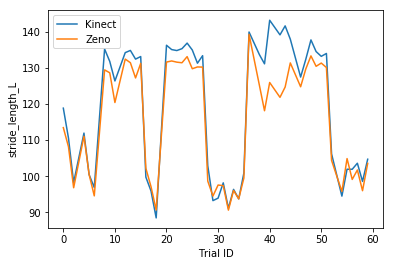

In [3]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

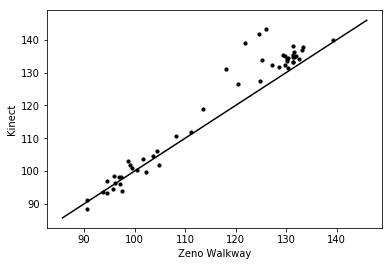

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_L'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

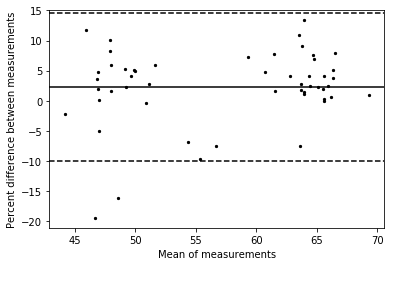

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,stance_percentage_L,stance_percentage_R,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.615950,0.733632,0.920910,0.902130,0.975094,0.965427,0.899903,0.934877,0.926987,0.966990,0.839795,0.847838
Spearman,0.585759,0.828823,0.838897,0.854179,0.895330,0.884720,0.612674,0.749901,0.787928,0.870827,0.729617,0.770085
Abs rel error,0.117338,0.099921,0.052378,0.054136,0.032145,0.030176,0.147966,0.186666,0.178379,0.223793,3.058879,2.824710
Bias,0.042454,0.045927,0.023068,0.029349,0.025281,0.011321,-0.161317,-0.208970,0.157703,0.197835,-0.153801,0.896461
Range,0.490852,0.415297,0.244509,0.259750,0.138748,0.163993,0.403491,0.325894,0.394644,0.310820,18.921802,14.489875


In [7]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,stance_percentage,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.807308,0.979527,0.975935,0.938264,0.958017,0.885290
Spearman,0.734910,0.897891,0.890976,0.661422,0.822676,0.776061
Abs rel error,0.085856,0.029120,0.027487,0.166119,0.200567,1.385038
Bias,0.046609,0.026506,0.018416,-0.184091,0.178717,9.055632
Range,0.336386,0.110020,0.135346,0.316168,0.317888,243.445287


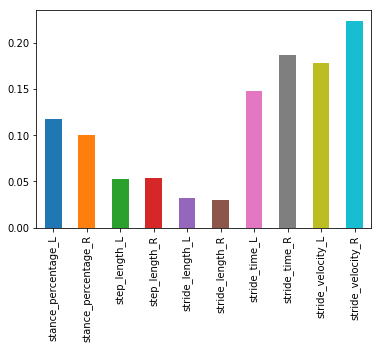

In [8]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [9]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.863106,0.891816
Spearman,0.741701,0.826422
Abs rel error,0.597847,0.569900
Bias,-0.011102,0.161987
Range,3.432341,2.660938


In [10]:
df_grouped.stride_length * 100

Pearson          97.593481
Spearman         89.097584
Abs rel error     2.748676
Bias              1.841557
Range            13.534552
Name: stride_length, dtype: float64

In [11]:
df_rel_error = abs(df_k - df_z) / df_z * 100

In [12]:
max_idx = df_rel_error.stride_length_L.idxmax()